In [1]:
import django, sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *

from scipy.spatial import ConvexHull

run_id = 665
s = 100000
p = 50

dto = DocDynamicTopic.objects

m = np.load('../tsne_results/data/run_{}_s_{}_m.npy'.format(run_id,s))
r_ind = np.load('../tsne_results/data/run_{}_s_{}_r_ind.npy'.format(run_id,s))
tsne_results = np.load('../tsne_results/data/run_{}_s_{}_p{}.npy'.format(run_id,s,p))

In [2]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.55,min_samples=50).fit(tsne_results)

labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 101


In [3]:
label_set = list(set(labels))
for l in set(labels):
    ind = np.argwhere(labels==l)
    print("\n##\nlabel: {}, {} documents".format(l,len(ind)))
    


##
label: 0, 8397 documents

##
label: 1, 537 documents

##
label: 2, 3385 documents

##
label: 3, 1872 documents

##
label: 4, 1495 documents

##
label: 5, 3048 documents

##
label: 6, 1670 documents

##
label: 7, 530 documents

##
label: 8, 3292 documents

##
label: 9, 703 documents

##
label: 10, 803 documents

##
label: 11, 689 documents

##
label: 12, 1051 documents

##
label: 13, 7219 documents

##
label: 14, 2735 documents

##
label: 15, 311 documents

##
label: 16, 651 documents

##
label: 17, 640 documents

##
label: 18, 598 documents

##
label: 19, 3638 documents

##
label: 20, 1804 documents

##
label: 21, 1535 documents

##
label: 22, 3984 documents

##
label: 23, 813 documents

##
label: 24, 589 documents

##
label: 25, 456 documents

##
label: 26, 3122 documents

##
label: 27, 1254 documents

##
label: 28, 486 documents

##
label: 29, 375 documents

##
label: 30, 824 documents

##
label: 31, 1389 documents

##
label: 32, 1473 documents

##
label: 33, 169 documents

##
la

In [8]:
dodf = True

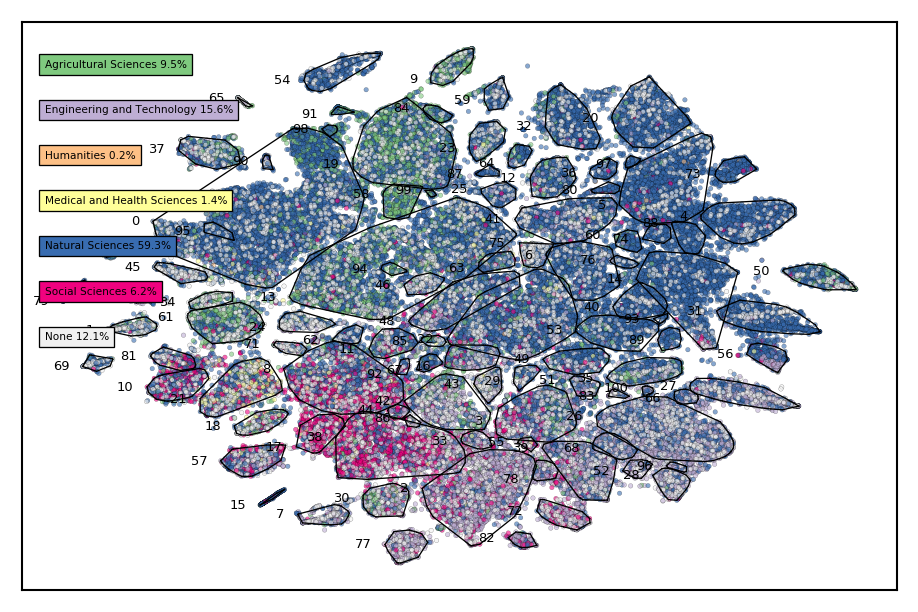

In [9]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)


import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(label_set), vmax=max(label_set))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

df = pd.DataFrame()

doc_df = pd.DataFrame()

colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = list(Doc.objects.filter(id__in=r_ind).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=r_ind,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]

for l in list(set(labels)):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        col = "grey"
        for c in oecd_cats:
            if r_ind[did[0]] in c['docs']:
                col = c['color']
        cs.append(col)
        xs.append(x)
        ys.append(y)
        dids.append(r_ind[did[0]])
        
    cdocs = Doc.objects.filter(id__in=dids).values('title','PY')
    rows = pd.DataFrame.from_dict(list(cdocs))
    rows['cluster'] = l
    doc_df = doc_df.append(rows)
    
    if dodf:
        dt = dto.filter(
            doc__id__in=dids,
            run_id=run_id
        ).aggregate(
            tscore=Sum('score')
        )

        dts = dto.filter(
            doc__id__in=dids,
            run_id=run_id
        ).values('topic__title').annotate(
            tscore=Sum('score'),
            tshare = Sum('score')/dt['tscore'],
            #cluster = l
        ).order_by('-tscore')

        rows = pd.DataFrame.from_dict(list(dts))
        rows['cluster'] = l
        df = df.append(rows)
                
    if l !=-1:
        points = np.array([(xs[i],ys[i]) for i,v in enumerate(xs)])
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            plt.plot(
                points[simplex, 0], 
                points[simplex, 1], 
                'k-',
                linewidth=0.5
            )
            for j in range(len(points[simplex,0])):                
                if i==0 and j==0:
                    px = points[simplex,0][j]
                    py = points[simplex,1][j]
                else:
                    if points[simplex,0][j] < px:
                        px = points[simplex,0][j]
                        py = points[simplex,1][j]                    

        plt.text(
            px-1,
            py,
            l,
            va="center",
            ha="right",
            fontsize=5
        )
        
    plt.scatter(
        xs,
        ys,
        s=3,
        #s=sizes,
        alpha=0.6,
        linewidth=0.1,
        c=cs,
        edgecolor='k'
    )
    
l = plt.xlim()[0]
t = plt.ylim()[1]
yextent = plt.ylim()[1]- plt.ylim()[0]
ysp = yextent*0.08

for i,c in enumerate(oecd_cats):
    plt.text(
        l*0.95,
        t-ysp-i*ysp,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/len(r_ind)),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,  
    labelbottom=False,
    left=False,
    labelleft=False
)
            
plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_clusters.png'.format(run_id,s,p))
plt.show()

In [5]:
df.to_csv('../tsne_results/data/run_{}_s_{}_p{}_clusters.csv'.format(run_id,s,p))

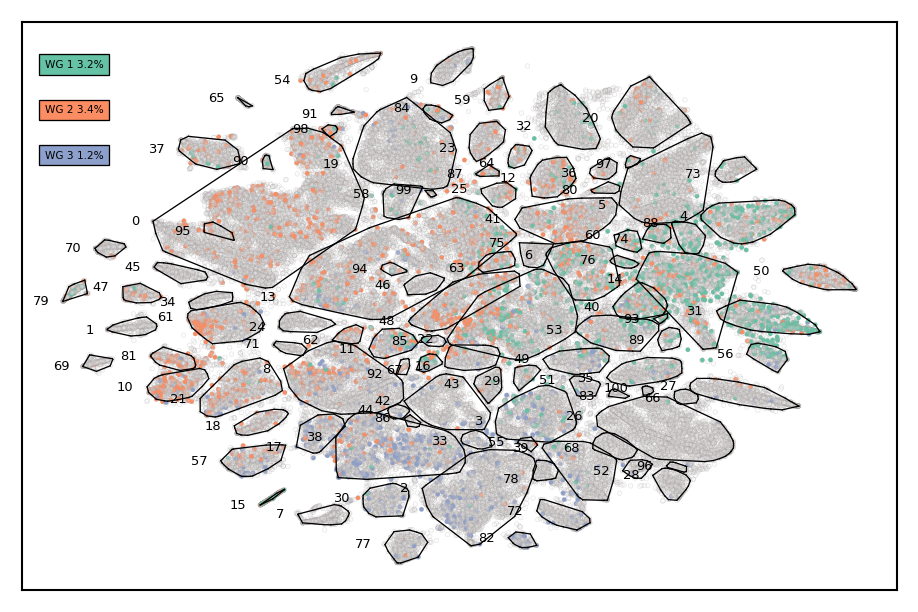

In [6]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)

colors=["#66c2a5","#fc8d62","#8da0cb"]



wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=r_ind,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]

for l in list(set(labels)):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    alphas=[]
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        col = "#F0F0F026"
        al = 0.5
        for c in wgs:
            if r_ind[did[0]] in c['docs']:
                col = c['color']
                al = 1
        alphas.append(al)
        cs.append(col)
        xs.append(x)
        ys.append(y)
        dids.append(r_ind[did[0]])
        
        
    if l !=-1:
        points = np.array([(xs[i],ys[i]) for i,v in enumerate(xs)])
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            plt.plot(
                points[simplex, 0], 
                points[simplex, 1], 
                'k-',
                linewidth=0.5
            )
            for j in range(len(points[simplex,0])):                
                if i==0 and j==0:
                    px = points[simplex,0][j]
                    py = points[simplex,1][j]
                else:
                    if points[simplex,0][j] < px:
                        px = points[simplex,0][j]
                        py = points[simplex,1][j]                    

        plt.text(
            px-1,
            py,
            l,
            va="center",
            ha="right",
            fontsize=5
        )
        
    plt.scatter(
        xs,
        ys,
        s=3,
        #alpha=alphas,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='#a39c9c99'
    )
    
l = plt.xlim()[0]
t = plt.ylim()[1]
yextent = plt.ylim()[1]- plt.ylim()[0]
ysp = yextent*0.08

for i,c in enumerate(wgs):
    plt.text(
        l*0.95,
        t-ysp-i*ysp,
        "WG {} {:.1%}".format(c['wg'],len(c['docs'])/len(r_ind)),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,  
    labelbottom=False,
    left=False,
    labelleft=False
)
            
plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_clusters_wgs.png'.format(run_id,s,p))
plt.show()

In [10]:
df

,topic__title,tscore,tshare,cluster
0,"{speci, distribut, rang}",205.480727,0.151004,0
1,"{popul, genet, divers}",162.765239,0.119613,0
2,"{plant, seed, power}",105.225857,0.077329,0
3,"{elev, ambient, leaf}",96.289161,0.070761,0
4,"{climat, chang, impact}",58.548248,0.043026,0
5,"{habitat, conserv, area}",55.463128,0.040759,0
6,"{communiti, microbi, composit}",45.325621,0.033309,0
7,"{increas, concentr, decreas}",30.838944,0.022663,0
8,"{growth, rate, econom}",24.288966,0.017850,0
9,"{temperatur, air, mean}",22.962474,0.016875,0
